In [1]:
import torch
import os

from torchvision.transforms import GaussianBlur

from util.dataset import load_celeb_a, load_mnist
from util.plot_util import plot_images, save_images
from util.model_util import load_checkpoint, load_model
from generate import rec_generate_images

In [2]:
def add_noise(x: torch.Tensor, mean=0.0, std=0.15):
    return (x + torch.randn_like(x) * std + mean)

def make_grayscale(x: torch.Tensor):
    """x: shape [batch_size, channels, width, height]"""
    if x.shape[1] == 1:
        return x
    return x.mean(dim=1, keepdim=True).repeat(1,3,1,1)

def make_sketch(x: torch.Tensor, kernel_size=21, eps=1e-10):
    gaussian = GaussianBlur(kernel_size=kernel_size, sigma=0.3*((kernel_size-1)*0.5-1)+0.8)
    gs = make_grayscale(x + 1)
    return gs / (gaussian(gs) + eps) - 1

In [3]:

# Setup
run_id = "CELEBA_UNET_epoch_700" #"MNIST_FINAL_epoch_100" #"CELEBA_CONDITIONAL_UNET_2_best_model" #"CELEBA_FINAL_FOURIER_epoch_1000"
n_images = 5
n_recursions = 3
normalized = True # True if images are in range [-1, 1]
eval_mode = False
save_reconstructions = False
image_dir = "ood_images/"
y_input_is_None = False
force_conditional = False # Use this when model name is wrong for a conditional model

# Make image dir
if save_reconstructions:
    os.makedirs(image_dir, exist_ok=True)

# Loading model and data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
checkpoint = load_checkpoint(f"checkpoints/{run_id}.pt")
model = load_model(checkpoint, device, force_conditional)

is_conditional = "conditional" in checkpoint["config"]["model"]["architecture"].lower() or force_conditional
grayscale = "mnist" in checkpoint['config']['dataset']['name'].lower()
use_fourier_sampling = checkpoint['config']['training']['use_fourier_sampling']
if grayscale:
    _, data = load_mnist(batch_size=checkpoint['config']['training']['batch_size'], single_channel=True)
else:
    data = load_celeb_a(batch_size=checkpoint['config']['training']['batch_size'], split='test')

model.to(device)
if eval_mode:
    model.eval()
else:
    model.train()

/media/simon/AE989A9A989A609F/Users/Simon/Documents/Github/KTH-DD2412-Idempotent-GenNets/util/model_util.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = tor

Files already downloaded and verified


100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


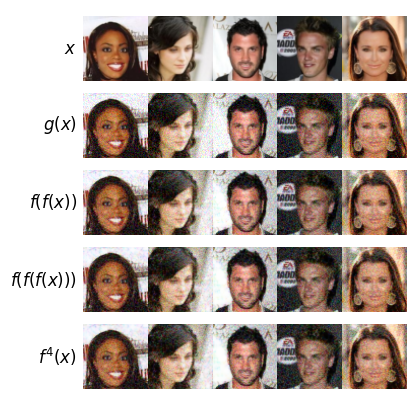

In [4]:
# Noise
original, reconstructed = rec_generate_images(
    model=model,
    device=device,
    data=data,
    n_images=n_images,
    n_recursions=n_recursions,
    reconstruct=True,
    use_fourier_sampling=use_fourier_sampling,
    transforms=[
        add_noise,
    ],
    loading_bar=True,
    with_label=is_conditional,
    y_input_is_None=y_input_is_None,
)
plot_images(
    original,
    reconstructed,
    grayscale=grayscale,
    normalized=normalized,
    transformed=True,
)

if save_reconstructions:
    save_images(
        original,
        reconstructed,
        grayscale=grayscale,
        normalized=normalized,
        transformed=True,
        output_path=os.path.join(image_dir, "added_noise.png"),
    )

100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


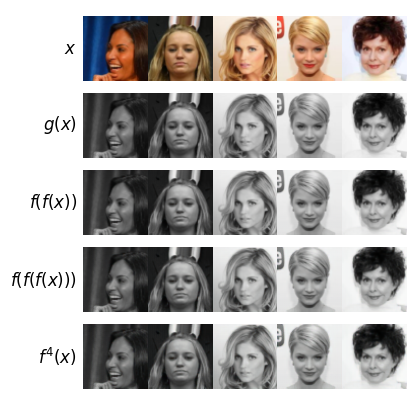

In [5]:
# Grayscale
original, reconstructed = rec_generate_images(
    model=model,
    device=device,
    data=data,
    n_images=n_images,
    n_recursions=n_recursions,
    reconstruct=True,
    use_fourier_sampling=use_fourier_sampling,
    transforms=[
        make_grayscale,
    ],
    loading_bar=True,
    with_label=is_conditional,
    y_input_is_None=y_input_is_None,
)
plot_images(
    original,
    reconstructed,
    grayscale=grayscale,
    normalized=normalized,
    transformed=True,
)

if save_reconstructions:
    save_images(
        original,
        reconstructed,
        grayscale=grayscale,
        normalized=normalized,
        transformed=True,
        output_path=os.path.join(image_dir, "grayscale.png"),
    )

100%|██████████| 5/5 [00:01<00:00,  4.26it/s]


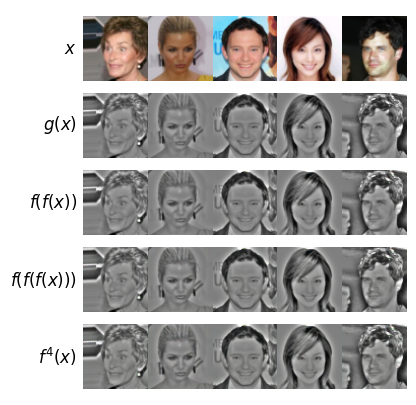

In [6]:
# Sketch
original, reconstructed = rec_generate_images(
    model=model,
    device=device,
    data=data,
    n_images=n_images,
    n_recursions=n_recursions,
    reconstruct=True,
    use_fourier_sampling=use_fourier_sampling,
    transforms=[
        make_sketch,
    ],
    loading_bar=True,
    with_label=is_conditional,
    y_input_is_None=y_input_is_None,
)
plot_images(
    original,
    reconstructed,
    grayscale=grayscale,
    normalized=normalized,
    transformed=True,
)

if save_reconstructions:
    save_images(
        original,
        reconstructed,
        grayscale=grayscale,
        normalized=normalized,
        transformed=True,
        output_path=os.path.join(image_dir, "sketch.png"),
    )